In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Re-PolyVore.zip'
extract_path = '/content'

# Create the folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [ ]:
!gdown 12JQF_8jaSUqgRC8a9ifbbA89fj_BN-_-

Downloading...
From: https://drive.google.com/uc?id=12JQF_8jaSUqgRC8a9ifbbA89fj_BN-_-
To: /content/re-poly-clustered.csv
100% 9.08M/9.08M [00:00<00:00, 28.4MB/s]


In [ ]:
import pandas as pd
df = pd.read_csv("re-poly-clustered.csv")
df

,Unnamed: 0.1,Unnamed: 0,outlook_id,clothing_type,id_inside_outlook,path_to_img,cluster
0,0,0,206867798,watches,5.jpg,Re-PolyVore/watches/206867798_5.jpg,4.0
1,1,1,216627343,watches,5.jpg,Re-PolyVore/watches/216627343_5.jpg,0.0
2,2,2,216731606,watches,7.jpg,Re-PolyVore/watches/216731606_7.jpg,2.0
3,3,3,215494910,watches,5.jpg,Re-PolyVore/watches/215494910_5.jpg,3.0
4,4,4,199682578,watches,6.jpg,Re-PolyVore/watches/199682578_6.jpg,4.0
...,...,...,...,...,...,...,...
126648,126648,126648,65956188,rings,7.jpg,Re-PolyVore/rings/65956188_7.jpg,1.0
126649,126649,126649,39385688,rings,8.jpg,Re-PolyVore/rings/39385688_8.jpg,2.0
126650,126650,126650,213792330,rings,6.jpg,Re-PolyVore/rings/213792330_6.jpg,2.0
126651,126651,126651,66775858,rings,4.jpg,Re-PolyVore/rings/66775858_4.jpg,2.0


In [ ]:
import numpy as np
supported_types = ['dress', 'hats', 'outwear', 'pants', 'shoes', 'skirt', 'top']
def create_samples(df):
  #for now using tops and pants only
  anchor_images_path = np.array([])
  positive_images_path = np.array([])
  negative_images_path = np.array([])
  for i in range(6):
    for j in range(6):
      if i == j:
        continue

      df_tops = df[df['clothing_type'] == supported_types[i]]
      df_tops = df_tops.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "clothing_type", "id_inside_outlook"])
      df_tops = df_tops.rename(columns={"path_to_img": "path_to_img_top", "cluster": "cluster_top"})
      df_pants = df[df['clothing_type'] == supported_types[j]]
      df_pants = df_pants.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "clothing_type", "id_inside_outlook"])
      df_pants = df_pants.rename(columns={"path_to_img": "path_to_img_pants", "cluster": "cluster_pants"})
      res_df = pd.merge(df_pants, df_tops, on='outlook_id')
      res_df = res_df.sort_values(by='cluster_top')
      anchor_images_path = np.concatenate((anchor_images_path, res_df['path_to_img_pants'].values))
      positive_images_path = np.concatenate((positive_images_path, res_df['path_to_img_top'].values))
      len_res_df = len(res_df)
      for cluster in range(5):
        df_for_negative = res_df[res_df['cluster_top']!=cluster]
        negative_images_path = np.concatenate((negative_images_path, df_for_negative['path_to_img_top'].sample(len_res_df - len(df_for_negative),random_state=0, replace=True).values))

  return anchor_images_path, positive_images_path, negative_images_path
anchor_images_path, positive_images_path, negative_images_path = create_samples(df)

In [ ]:
!pip install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:


image_count = len(anchor_images_path)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images_path)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images_path)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images_path)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
embedding.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 782s 439ms/step - loss: 0.4828 - val_loss: 0.4686
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 714s 422ms/step - loss: 0.4421 - val_loss: 0.4594
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 713s 421ms/step - loss: 0.4367 - val_loss: 0.4592
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 714s 423ms/step - loss: 0.4309 - val_loss: 0.4545
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 746s 425ms/step - loss: 0.4305 - val_loss: 0.4620
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 716s 424ms/step - loss: 0.4281 - val_loss: 0.4592
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 717s 424ms/step - loss: 0.4199 - val_loss: 0.4667
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 720s 425ms/step - loss: 0.4153 - val_loss: 0.4595
Epoch 9/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 718s 425ms/step - loss: 0.4085 - val_loss: 0.4605
Epoch 10/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 747s 442ms/step - loss: 0.4039 - val_loss: 0.4635


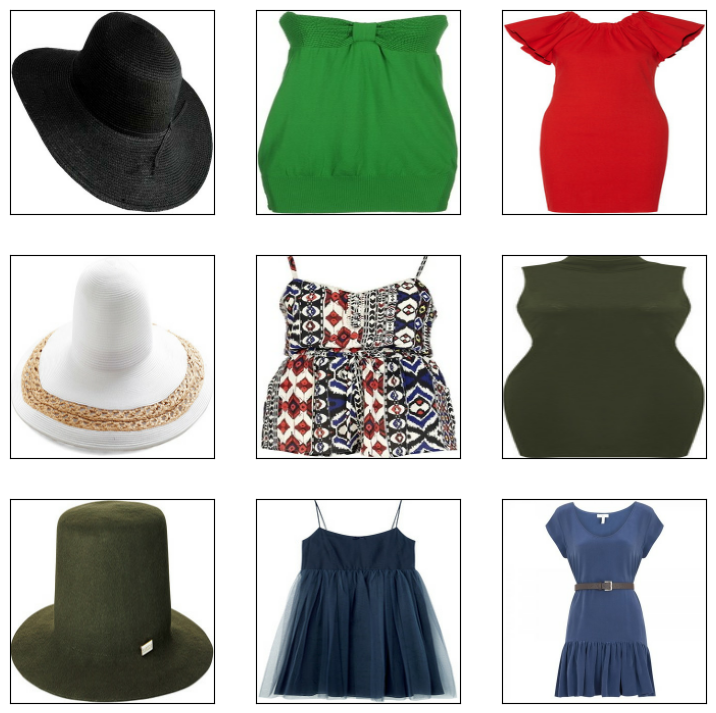

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

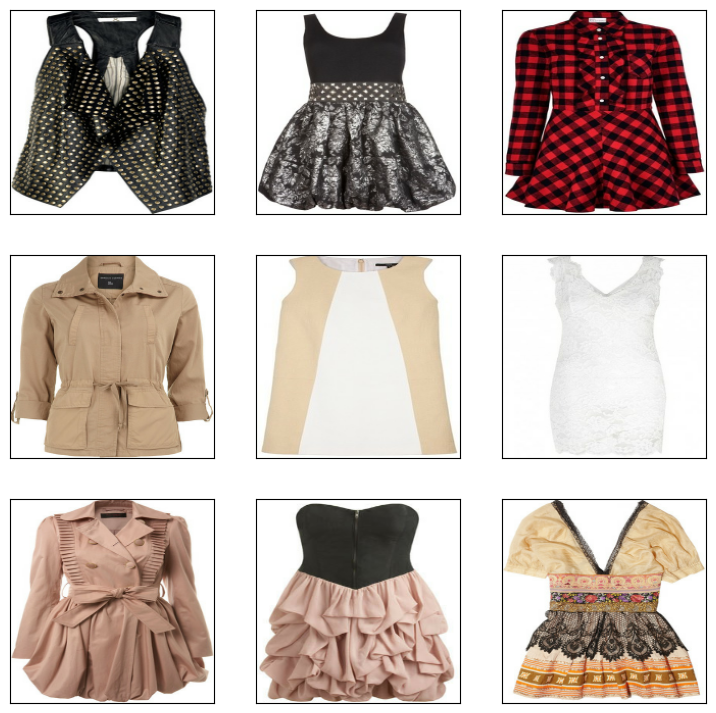

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99659383
Negative similarity 0.9959501


In [ ]:
!gdown 1rnoz2zYuxb4p6JjlVQCt9OzR6Yd7IIbm

Downloading...
From: https://drive.google.com/uc?id=1rnoz2zYuxb4p6JjlVQCt9OzR6Yd7IIbm
To: /content/traditional.zip
100% 706k/706k [00:00<00:00, 135MB/s]


In [ ]:
!unzip traditional.zip

Archive:  traditional.zip
  inflating: cshirt_chineese.jpg     
  inflating: shirt_ukrainian.jpg     
  inflating: skirt_chineese.jpg      
  inflating: skirt_ukrainian.jpg     


In [ ]:
uk_sk, uk_sh, ch_sk, ch_sh = (preprocess_image("/content/skirt_ukrainian.jpg"), preprocess_image("/content/shirt_ukrainian.jpg"),
                              preprocess_image("/content/skirt_chineese.jpg"), preprocess_image("/content/cshirt_chineese.jpg"))
uk_sk_embedding, uk_sh_embedding, ch_sk_embedding, ch_sh_embedding = (
    embedding(resnet.preprocess_input(np.array([uk_sk]))),
    embedding(resnet.preprocess_input(np.array([uk_sh]))),
    embedding(resnet.preprocess_input(np.array([ch_sk]))),
    embedding(resnet.preprocess_input(np.array([ch_sh])))
)

In [ ]:
embedding.save("siameese_embedding.h5", save_format='h5')

In [ ]:
siamese_model.save("/content/siamese_model.h5")

In [ ]:
!pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [7]:
!git clone https://github.com/KrishGupta88/smart-wardrobe.git
%cd smart-wardrobe


fatal: destination path 'smart-wardrobe' already exists and is not an empty directory.
/content/smart-wardrobe


In [9]:
!ls /content


drive  sample_data  smart-wardrobe


In [11]:
!ls "/content/drive/MyDrive/Colab Notebooks"


'Copy of Untitled2.ipynb'   Untitled0.ipynb   ZIPBOLT_INNOVATIONS_LATEST.ipynb
 Model_Training.ipynb	    Untitled1.ipynb


In [12]:
!cp "/content/drive/MyDrive/Colab Notebooks/Model_Training.ipynb" .


In [13]:
!git config --global user.email "krishgupta24august@gmail.com"
!git config --global user.name "KrishGupta88"

!git add .
!git commit -m "Added Smart Wardrobe Notebook"
!git branch -M main
!git push -u origin main


[main (root-commit) a39a420] Added Smart Wardrobe Notebook
 1 file changed, 1 insertion(+)
 create mode 100644 Model_Training.ipynb
fatal: could not read Username for 'https://github.com': No such device or address
